# Emotion Categorization Using TensorFlow

# Import Library untuk proyek



In [1]:
from google.colab import drive

#untuk dataframe
import pandas as pd
import re

#Import sklearn untuk preprocessing dan plit data
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

#Import tensorflow
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding
print(tf.__version__)

#Import matplotlib untuk visualisasi data
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'google'

# Mengimport Dataset dan Melakukan Preprocessing Data

Dataset yang digunakan merupakan "Emotions Dataset for NLP" -> Train.txt [link text](https://www.kaggle.com/praveengovi/emotions-dataset-for-nlp)

Data yang diambil hanya data train.txt karena akan dilakukan simulasi pembagian antara train set dan validation set yaitu sebesar 80% untuk train set dan 20% untuk validation set.

Data terbagi atas 2 columns yaitu kolom "Document" dan kolom "Emotion". Model dibuat untuk mengembangkan emotion classification menggunakan NLP. Selanjutnya model ini dapat digunakan untuk menjawab pertanyaan seperti "sentimen apa yang didapatkan berdasarkan komentar pelanggan?".

In [4]:
#mount drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Dilakukan import dataset dan penambahan label untuk header yaitu "Document" dan "Emotion"

In [15]:
#importing data
data = pd.read_csv("/content/drive/My Drive/Dicoding/Submission1/train.txt", sep = ";", names = ["Document", "Emotion"])
data.head()

,Document,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


Mengecek klasifikasi data dan jumlahnya.

In [16]:
data["Emotion"].value_counts()

joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: Emotion, dtype: int64

Melakukan preprocessing data yaitu penghapusan special character dan "Document" sebelumnya.

In [17]:
# Menghapus special character di kolom text
data["Doc"] = data["Document"].map(lambda x: re.sub(r'\W+', ' ', x))
# drop kolom document lama
data = data.drop(["Document"], axis=1)
data.head()

,Emotion,Doc
0,sadness,i didnt feel humiliated
1,sadness,i can go from feeling so hopeless to so damned...
2,anger,im grabbing a minute to post i feel greedy wrong
3,love,i am ever feeling nostalgic about the fireplac...
4,anger,i am feeling grouchy


Melakukan pengecekan nilai kosong / NaN

In [18]:
data.isnull().values.any()

False

Diketahui bahwa nilai kosongnya "False" yang artinya tidak ada nilai kosong pada data.

Selanjutnya, akan dilakukan pelabelan pada Emotion.

In [19]:
category = pd.get_dummies(data.Emotion)
data_baru = pd.concat([data, category], axis=1)
data_baru = data_baru.drop(columns="Emotion")
data_baru

,Doc,anger,fear,joy,love,sadness,surprise
0,i didnt feel humiliated,0,0,0,0,1,0
1,i can go from feeling so hopeless to so damned...,0,0,0,0,1,0
2,im grabbing a minute to post i feel greedy wrong,1,0,0,0,0,0
3,i am ever feeling nostalgic about the fireplac...,0,0,0,1,0,0
4,i am feeling grouchy,1,0,0,0,0,0
...,...,...,...,...,...,...,...
15995,i just had a very brief time in the beanbag an...,0,0,0,0,1,0
15996,i am now turning and i feel pathetic that i am...,0,0,0,0,1,0
15997,i feel strong and good overall,0,0,1,0,0,0
15998,i feel like this was such a rude comment and i...,1,0,0,0,0,0


Agar dapat diproses oleh model, nilai-nilai dari dataframe diubah ke dalam tipe data numpy array menggunakan atribut values.

In [28]:
text = data_baru["Doc"].values
label = data_baru[["anger", "fear", "joy", "love", "sadness", "surprise"]].values

# Membagi data menjadi data training dan data validation

Membagi data sebagai train set sebanyak 80% dan validation set sebanyak 20%.

In [29]:
text_train, text_val, label_train, label_val = train_test_split(text, label, test_size = 0.2)

# Menggunakan fungsi tokenizer

In [30]:
tokenizer = Tokenizer(num_words=5000, oov_token='x')
tokenizer.fit_on_texts(text_train)
tokenizer.fit_on_texts(text_val)
 
seq_train = tokenizer.texts_to_sequences(text_train)
seq_val = tokenizer.texts_to_sequences(text_val)
 
padded_train = pad_sequences(seq_train)
padded_val = pad_sequences(seq_val)

# Model Menggunakan LSTM dan Sequential

In [49]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=5000, output_dim=16),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])

Model compile dengan optimizer Adam.

In [50]:
Adam(learning_rate=0.00146, name='Adam')
model.compile(optimizer = 'Adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])

Melakukan implementasi callback untuk mendapatkan akurasi > 90%

In [51]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.9 and logs.get('val_accuracy')>0.9):
      print("\nAkurasi train dan validasi telah mencapai nilai > 90%!")
      self.model.stop_training = True
callbacks = myCallback()

Selanjutnya, melatih model kita dengan memanggil fungsi fit().

In [52]:
num_epochs = 30
history = model.fit(padded_train, label_train, epochs=num_epochs, validation_data=(padded_val, label_val), verbose=1, callbacks=[callbacks])

Epoch 1/30
400/400 [==============================] - 13s 30ms/step - loss: 1.4735 - accuracy: 0.3654 - val_loss: 1.1648 - val_accuracy: 0.4575
Epoch 2/30
400/400 [==============================] - 11s 29ms/step - loss: 1.0095 - accuracy: 0.5437 - val_loss: 0.8103 - val_accuracy: 0.6969
Epoch 3/30
400/400 [==============================] - 12s 29ms/step - loss: 0.5520 - accuracy: 0.8086 - val_loss: 0.5249 - val_accuracy: 0.8247
Epoch 4/30
400/400 [==============================] - 11s 29ms/step - loss: 0.3169 - accuracy: 0.8884 - val_loss: 0.4264 - val_accuracy: 0.8519
Epoch 5/30
400/400 [==============================] - 11s 29ms/step - loss: 0.1937 - accuracy: 0.9326 - val_loss: 0.3627 - val_accuracy: 0.8844
Epoch 6/30
400/400 [==============================] - 12s 29ms/step - loss: 0.1350 - accuracy: 0.9511 - val_loss: 0.4092 - val_accuracy: 0.8809
Epoch 7/30
400/400 [==============================] - 12s 29ms/step - loss: 0.1024 - accuracy: 0.9656 - val_loss: 0.3474 - val_accuracy:

# Mengeluarkan Plot Accuracy dan Plot Loss untuk Train Set dan Validation Set

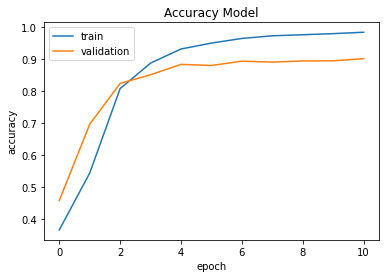

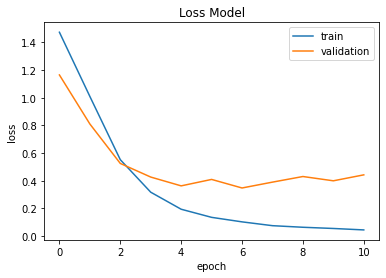

In [54]:
# Plot Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy Model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Plot Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()